In [13]:
#D'abord vérifier si on a du Lenet

In [1]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import time
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model, preprocessing 
from keras.applications.imagenet_utils import preprocess_input
from sklearn import metrics

from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline




Using TensorFlow backend.


In [11]:
def dictionnaire_conversion():
    dic_labels_to_num={}
    dic_num_to_labels={}

    dic_labels_to_num["autre"]=0
    dic_labels_to_num["chevreuil"]=1
    dic_labels_to_num["corneille"]=2
    dic_labels_to_num["faisan"]=3
    dic_labels_to_num["lapin"]=4
    dic_labels_to_num["pigeon"]=5
    dic_labels_to_num["oiseau"]=6
    
    dic_num_to_labels[0]="autre"
    dic_num_to_labels[1]="chevreuil"
    dic_num_to_labels[2]="corneille"
    dic_num_to_labels[3]="faisan"
    dic_num_to_labels[4]="lapin"
    dic_num_to_labels[5]="pigeon"
    dic_num_to_labels[6]="oiseau"
    
    return dic_labels_to_num,dic_num_to_labels




def build_model(width, height, depth, classes,drop_out_rate):
	# initialize the input shape and channels dimension to be
	# "channels last" ordering
	inputShape = (height, width, depth)
	chanDim = -1
	# build the model using Keras' Sequential API
	model = Sequential([
		# CONV => RELU => BN => POOL layer set
		Conv2D(30, (5, 5), padding="same", input_shape=inputShape),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),
        
		# (CONV => RELU => BN) * 2 => POOL layer set
		Conv2D(16, (3, 3), padding="same"),
		Activation("relu"),
		BatchNormalization(axis=chanDim),
		MaxPooling2D(pool_size=(2, 2)),

        
		# first (and only) set of FC => RELU layers
		Flatten(),
		Dense(128),
		Activation("relu"),
		BatchNormalization(),
		Dropout(drop_out_rate),
        
		# softmax classifier
		Dense(classes),
		Activation("softmax")
	])
	# return the built model to the calling function
	return model



#Paramètres

#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2
epochs=200
batch_size = 600
zoom_range = 1.25
horizontal_flip = True
Minimum_Number_Class=100
dropout_rate=0.3
#steps_per_epoch=len(data_train)//batch_size
steps_per_epoch=1
#validation_steps=len(data_test)//batch_size
validation_steps=1



base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur_bigger.csv'

df=pd.read_csv(generateur_path)
df.drop('labels',inplace=True,axis=1)

df["class"].unique()
for c in df:
    print(''+c+':',len(df[c].unique()))
df["class"].unique()


All_Unique=df["class"].unique()
Utilisable=[]
for i in df["class"].unique():
    if df["class"][df["class"]==i].count()>Minimum_Number_Class:
        Utilisable.append(i)
Utilisable
Non_Utilisable=set(All_Unique)-set(Utilisable)
Non_Utilisable
for i in Non_Utilisable:
    df=df[df["class"]!=i]
df=df[df["class"]!="oiseau"]  
df["class"].unique()


for i in range(len(df["class"])):
    image_name=df["img_paths"].iloc[i]
    df["img_paths"].iloc[i]=os.path.join(base_img_paths,image_name)
    
    
    
dic_labels_to_num,dic_num_to_labels=dictionnaire_conversion()

n_path="/mnt/VegaSlowDataDisk/c3po/Annotation_automatique/"
gen_imagettes=pd.read_csv(n_path+"fp+an_gen_tf.csv")

folder_imagettes="tf_200ep/"

liste_img_paths=[]
for i in range(len(gen_imagettes)):
    liste_img_paths.append(n_path+folder_imagettes+gen_imagettes["imagetteName"].iloc[i])

gen_imagettes["img_paths"]=liste_img_paths
gen_imagettes.head()

gen_imagettes["class"]="autre"

for i in range(len(gen_imagettes)):
    if gen_imagettes["IsFP"].iloc[i]==0:
        gen_imagettes["class"].iloc[i]=dic_num_to_labels[gen_imagettes["reel_classe"].iloc[i]]
    
gen_imagettes.head()      
    
    
        
    
gen_imagettes=gen_imagettes[gen_imagettes["reel_classe"]!=0]

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'max_cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index','reel_classe','IsFP','predict_cat']
gen_imagettes.drop(to_drop,inplace=True,axis=1)
gen_imagettes.head()


n_path="/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_images/"



fp_new=pd.read_csv("/mnt/VegaSlowDataDisk/c3po_interface/bin/fp_threshold/table_fp_new.csv")

liste_img_paths=[]
for i in range(len(fp_new)):
    liste_img_paths.append(n_path+fp_new["imagetteName"].iloc[i])

fp_new["img_paths"]=liste_img_paths
#imagetteNamefp_new.head()

fp_new["class"]="autre"
fp_new.columns

to_drop=['path', 'filename', 'imagetteName', 'max_cat', 'cat', 'xmin', 'xmax','ymin', 'ymax', 'former_index']

fp_new.drop(to_drop,axis=1,inplace=True)

#df=pd.concat([df,fp_new])


#gen_imagettes.drop("predict_cat",inplace=True,axis=1)
df=pd.concat([df,gen_imagettes,fp_new])

df=df[df["class"]!="oiseau"]

class: 13
img_paths: 6220


/home/marcpozzo/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/marcpozzo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:167: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [14]:
from numpy.random import seed
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)


test_data_generator = ImageDataGenerator()
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]


Found 42558 validated image filenames belonging to 6 classes.
Found 10640 validated image filenames belonging to 6 classes.


In [13]:
#First test the influence of number of epochs on the other recall

In [16]:
val_acc=[]
acc=[]
val_loss=[]
loss=[]

seed(1)
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6,0.2)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))

seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
val_acc.append(history.history["val_acc"])
acc.append(history.history["acc"])
val_loss.append(history.history["val_loss"])
loss.append(history.history["loss"])
print(metrics.classification_report(y_predict,y_test,digits=5))


Train on 42558 samples, validate on 10640 samples
Epoch 1/10
42558/42558 [==============================] - 24s 560us/sample - loss: 0.3879 - acc: 0.8898 - val_loss: 1.2491 - val_acc: 0.9114
Epoch 2/10
42558/42558 [==============================] - 23s 530us/sample - loss: 0.1671 - acc: 0.9494 - val_loss: 0.5465 - val_acc: 0.9055
Epoch 3/10
42558/42558 [==============================] - 24s 563us/sample - loss: 0.1363 - acc: 0.9566 - val_loss: 0.8151 - val_acc: 0.9111
Epoch 4/10
42558/42558 [==============================] - 24s 563us/sample - loss: 0.1198 - acc: 0.9620 - val_loss: 1.0556 - val_acc: 0.9114
Epoch 5/10
42558/42558 [==============================] - 24s 568us/sample - loss: 0.1047 - acc: 0.9663 - val_loss: 0.8388 - val_acc: 0.9114
Epoch 6/10
42558/42558 [==============================] - 24s 569us/sample - loss: 0.0901 - acc: 0.9707 - val_loss: 0.7038 - val_acc: 0.9108
Epoch 7/10
42558/42558 [==============================] - 24s 572us/sample - loss: 0.0839 - acc: 0.9720 

/home/marcpozzo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


              precision    recall  f1-score   support

         0.0    0.99938   0.91287   0.95417     10616
         1.0    0.00000   0.00000   0.00000        15
         2.0    0.01225   0.71429   0.02410         7
         3.0    0.00000   0.00000   0.00000         1
         4.0    0.00000   0.00000   0.00000         1
         5.0    0.00000   0.00000   0.00000         0

    accuracy                        0.91128     10640
   macro avg    0.16861   0.27119   0.16304     10640
weighted avg    0.99714   0.91128   0.95203     10640

Train on 42558 samples, validate on 10640 samples
Epoch 1/10
42558/42558 [==============================] - 24s 571us/sample - loss: 0.0650 - acc: 0.9778 - val_loss: 1.2328 - val_acc: 0.9116
Epoch 2/10
42558/42558 [==============================] - 24s 562us/sample - loss: 0.0570 - acc: 0.9806 - val_loss: 1.0334 - val_acc: 0.9109
Epoch 3/10
42558/42558 [==============================] - 26s 615us/sample - loss: 0.0529 - acc: 0.9826 - val_loss: 0.9402 - 

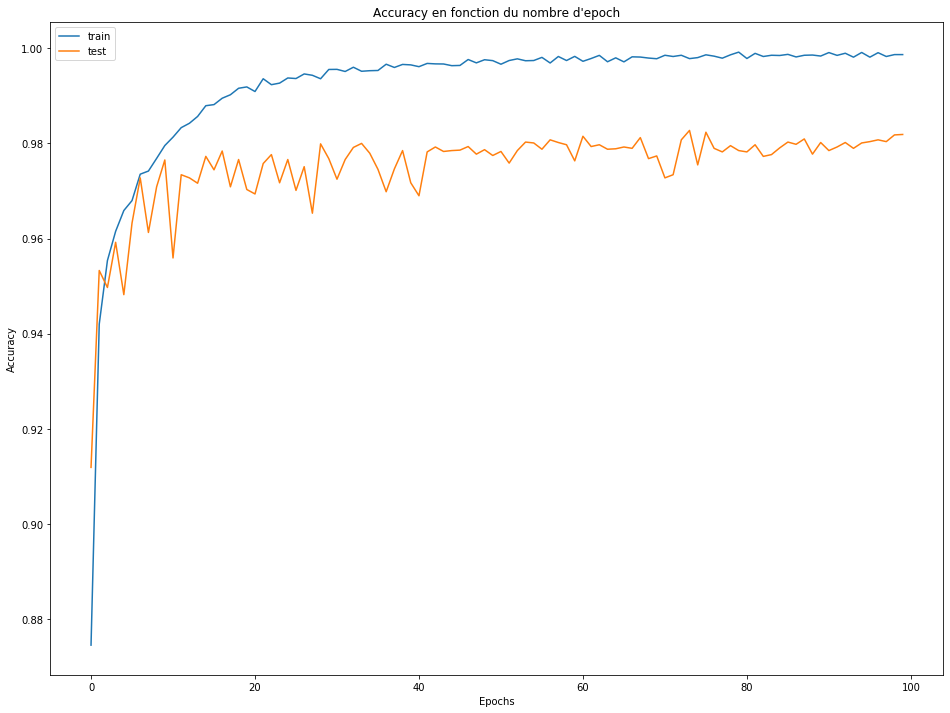

In [16]:
import itertools

val_acc_liste = list(itertools.chain(*val_acc))
acc_liste = list(itertools.chain(*acc))

plt.figure(figsize=(16,12))

plt.plot(acc_liste,label="train");
plt.plot(val_acc_liste,label="test");
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Accuracy en fonction du nombre d'epoch");
plt.legend();

In [5]:
df["class"]

1           autre
2       corneille
3       corneille
4          pigeon
5           autre
          ...    
6215        autre
6216       pigeon
6217        autre
6218       pigeon
6219        autre
Name: class, Length: 5966, dtype: object

In [17]:
seed(1)
tf.random.set_seed(2)
model = build_model(28, 28, 3, 6)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics=["acc"])
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))



seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))


seed(1)
tf.random.set_seed(2)
history=model.fit(x_train,y_train,epochs=10,validation_data=(x_test,y_test))
y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

model.save("gen")


Train on 42558 samples, validate on 10640 samples
Epoch 1/10
42558/42558 [==============================] - 33s 775us/sample - loss: 0.5111 - acc: 0.8633 - val_loss: 0.4018 - val_acc: 0.9185
Epoch 2/10
42558/42558 [==============================] - 33s 772us/sample - loss: 0.2872 - acc: 0.9219 - val_loss: 0.2898 - val_acc: 0.9246
Epoch 3/10
42558/42558 [==============================] - 33s 772us/sample - loss: 0.2433 - acc: 0.9308 - val_loss: 0.3378 - val_acc: 0.9193
Epoch 4/10
42558/42558 [==============================] - 32s 763us/sample - loss: 0.2204 - acc: 0.9367 - val_loss: 0.1677 - val_acc: 0.9478
Epoch 5/10
42558/42558 [==============================] - 33s 776us/sample - loss: 0.2018 - acc: 0.9411 - val_loss: 0.1920 - val_acc: 0.9472
Epoch 6/10
42558/42558 [==============================] - 33s 766us/sample - loss: 0.1865 - acc: 0.9458 - val_loss: 0.1564 - val_acc: 0.9494
Epoch 7/10
42558/42558 [==============================] - 33s 764us/sample - loss: 0.1759 - acc: 0.9491 

In [19]:
seed(1)
tf.random.set_seed(2)

data_train,data_test= train_test_split(df,stratify=df["class"], test_size=test_size,random_state=42)
train_data_generator = ImageDataGenerator()


test_data_generator = ImageDataGenerator()
    #preprocessing_function = preprocess_input)




train_generator = train_data_generator.flow_from_dataframe(dataframe=data_train,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_train) )


test_generator = test_data_generator.flow_from_dataframe(dataframe=data_test,
                                                          directory="",
                                                           x_col = "img_paths",
                                                           class_mode ="sparse",
                                                          target_size = (28 , 28), 
                                                          batch_size = len(data_test))

gen=train_generator[0]

x_train=gen[0]
y_train=gen[1]



gen_test=test_generator[0]

x_test=gen_test[0]
y_test=gen_test[1]

Found 42558 validated image filenames belonging to 6 classes.
Found 10640 validated image filenames belonging to 6 classes.


In [4]:
df

,class,img_paths
1,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
2,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
3,corneille,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
4,pigeon,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
5,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
...,...,...
6215,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
6216,pigeon,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
6217,autre,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...
6218,pigeon,/home/marcpozzo/Desktop/c3po/Images_aquises/Re...


In [29]:
#Paramètres
base_img_paths="/home/marcpozzo/Desktop/c3po/Images_aquises/"
generateur_path='/mnt/VegaSlowDataDisk/c3po/Images_aquises/generateur.csv'
#generateur_path='/mnt/VegaSlowDataDisk/c3po/Chaine_de_traitement/Train_imagettes_annotées/type_oiseau/Materiel/generateur.csv'
test_size=0.2
epochs=10
batch_size = 600
zoom_range = 1.2
horizontal_flip = True
dropout_rate=0.3





val_accuracy=[]
accuracy=[]

datagen = ImageDataGenerator(rotation_range = 10,zoom_range = 1.1)
#featurewise_center=True,
#featurewise_std_normalization=True,
#rotation_range=20,
#width_shift_range=0.2,
#height_shift_range=0.2,
#horizontal_flip=True
    
    

datagen.fit(x_train)

longueur=round(len(x_train)) 
for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))




for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))



for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))


for e in range(epochs):
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=600):
        history=model.fit(x_batch, y_batch,validation_data=(x_test,y_test),verbose=0)
        val_accuracy.append(history.history['val_acc'])
        accuracy.append(history.history["acc"])
        batches += 1
        if batches >= len(x_train) / longueur:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break 

y_predict=model.predict(x_test).argmax(axis=1)
print(metrics.classification_report(y_predict,y_test,digits=5))

              precision    recall  f1-score   support

           0    0.99051   0.98654   0.98852      9736
           1    0.94118   0.90566   0.92308        53
           2    0.86520   0.86308   0.86414       409
           3    0.75000   0.91429   0.82403       105
           4    0.61194   0.73214   0.66667        56
           5    0.87543   0.90036   0.88772       281

    accuracy                        0.97707     10640
   macro avg    0.83904   0.88368   0.85903     10640
weighted avg    0.97804   0.97707   0.97744     10640

              precision    recall  f1-score   support

           0    0.98752   0.99059   0.98905      9667
           1    0.96078   0.89091   0.92453        55
           2    0.88235   0.83721   0.85919       430
           3    0.82031   0.82677   0.82353       127
           4    0.67164   0.78947   0.72581        57
           5    0.91349   0.86842   0.89039       304

    accuracy                        0.97735     10640
   macro avg    0.87268